## Setup

First, let's import the necessary libraries and set up our environment.

In [5]:
!git clone https://github.com/Adam-Ousse/notmiwae_pytorch.git

Cloning into 'notmiwae_pytorch'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 26 (delta 6), reused 26 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 26.24 KiB | 447.00 KiB/s, done.
Resolving deltas: 100% (6/6), done.


In [1]:
import sys
import os

# Add the parent directory to the path so we can import our notmiwae_pytorch module
os.chdir("../..")
# print(os.getcwd())
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Import our not-MIWAE implementation
from notmiwae_pytorch import NotMIWAE, MIWAE, Trainer, BaseMissingProcess
from notmiwae_pytorch.utils import (
    set_seed, 
    imputation_rmse,
    standardize,
)
from typing import Optional, Literal, Union
import torch.nn as nn 
import torch.nn.functional as F
# Set random seed for reproducibility
set_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Load and Prepare Data

We'll use the UCI Wine Quality dataset, following the experimental setup in the paper.

In [2]:
# Load the Wine Quality dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = pd.read_csv(url, sep=';')

print(f"Dataset shape: {data.shape}")
print(f"\nColumn names: {list(data.columns)}")
print(f"\nFirst few rows:")
data.head()

Dataset shape: (4898, 12)

Column names: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

First few rows:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
# Drop the quality column (target) - we only want features
X = data.drop('quality', axis=1).values.astype(np.float32)
N, D = X.shape

print(f"Data shape: N={N} samples, D={D} features")

# Standardize the data
X_std, mean, std = standardize(X)

# Random permutation
perm = np.random.permutation(N)
X_std = X_std[perm]

print(f"\nData statistics after standardization:")
print(f"Mean: {X_std.mean(axis=0).round(4)}")
print(f"Std: {X_std.std(axis=0).round(4)}")

Data shape: N=4898 samples, D=11 features

Data statistics after standardization:
Mean: [-0.  0.  0. -0.  0. -0. -0. -0.  0. -0. -0.]
Std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 2. Introduce Missing Values (MNAR Mechanism)

Following the paper's experimental setup, we introduce **self-masking MNAR**:
- In the first D/2 dimensions, values above the mean are missing
- This creates a challenging scenario where the missingness depends on the values themselves

In [4]:
def introduce_directional_mnar(X, signs=None, threshold=0.0, strength=3.0, base_prob=0.1):
    """
    Introduce MNAR missing values with directional control per feature.
    
    Args:
        X: Data array (N, D)
        signs: Array of +1/-1 for each feature. +1 = high→missing, -1 = low→missing
               If None, alternates: first half +1, second half -1
        threshold: Threshold value (default 0.0, assumes standardized data)
        strength: Controls how strongly distance from threshold affects missingness probability
        base_prob: Minimum probability of missingness
    
    Returns:
        X_nan: Data with NaN for missing values
        X_filled: Data with missing values filled with 0
        mask: Binary mask (1=observed, 0=missing)
        signs: The signs used
    """
    N, D = X.shape
    
    # Default signs: first half high→missing, second half low→missing
    if signs is None:
        signs = np.ones(D)
        signs[D//2:] = -1.0
    
    # Initialize mask (all observed)
    mask = np.ones_like(X)
    
    # For each feature, compute missingness probability based on distance from threshold
    for d in range(D):
        # Distance from threshold (signed)
        distance = X[:, d] - threshold
        
        # Apply sign: 
        # If sign=+1 (high→missing): positive distance → higher prob
        # If sign=-1 (low→missing): negative distance → higher prob
        signed_distance = signs[d] * distance
        
        # Compute probability using sigmoid: p = base_prob + (1-base_prob) * sigmoid(strength * signed_distance)
        # This makes probability increase smoothly from base_prob to ~1.0 as signed_distance increases
        prob_missing = base_prob + (1 - base_prob) * (1 / (1 + np.exp(-strength * signed_distance)))
        
        # Sample from Bernoulli: each value independently becomes missing with computed probability
        missing_indicators = np.random.binomial(1, prob_missing, size=N)
        
        # Update mask (0 = missing, 1 = observed)
        mask[:, d] = 1 - missing_indicators
    
    # Create versions with missing values
    X_nan = X.copy()
    X_nan[mask == 0] = np.nan
    
    X_filled = X.copy()
    X_filled[mask == 0] = 0
    
    return X_nan, X_filled, mask, signs

In [5]:
def introduce_sinusoidal_mnar(X, amplitude=1.0, frequency=1.0, phase=0.0, base_prob=0.3, seed=42):
    """
    Introduce MNAR missing values with a sinusoidal pattern.
    
    The probability of missingness follows a sinusoidal function of the feature value:
        p(missing | x) = base_prob + (1 - base_prob) * 0.5 * (1 + sin(frequency * x + phase))
    
    This creates a cyclic pattern where certain value ranges are more likely to be missing,
    simulating scenarios like:
    - Periodic sensor failures at certain value ranges
    - Cyclical censoring in time-series data
    - Non-monotonic reporting patterns
    
    Args:
        X: Data array (N, D)
        amplitude: Controls the strength of the sinusoidal effect (0 to 1)
        frequency: Controls how many "cycles" of missingness across the value range
        phase: Phase shift of the sinusoid (per feature or single value)
        base_prob: Baseline probability of missingness
        seed: Random seed
    
    Returns:
        X_nan: Data with NaN for missing values
        X_filled: Data with missing values filled with 0
        mask: Binary mask (1=observed, 0=missing)
        params: Dict with the parameters used
    """
    np.random.seed(seed)
    N, D = X.shape
    
    # Handle phase: can be single value or per-feature
    if np.isscalar(phase):
        phases = np.full(D, phase)
    else:
        phases = np.array(phase)
    
    # Handle frequency: can be single value or per-feature
    if np.isscalar(frequency):
        frequencies = np.full(D, frequency)
    else:
        frequencies = np.array(frequency)
    
    # Initialize mask (all observed)
    mask = np.ones_like(X)
    
    # For each feature, compute missingness probability based on sinusoidal pattern
    for d in range(D):
        # Sinusoidal probability: oscillates between base_prob and 1.0
        # sin output is in [-1, 1], we map to [0, 1] then scale by amplitude
        sin_component = np.sin(frequencies[d] * X[:, d] + phases[d])
        # Map from [-1, 1] to [0, 1]
        sin_normalized = 0.5 * (1 + sin_component)
        # Scale by amplitude and add base probability
        prob_missing = base_prob + amplitude * (1 - base_prob) * sin_normalized
        
        # Sample from Bernoulli
        missing_indicators = np.random.binomial(1, prob_missing, size=N)
        mask[:, d] = 1 - missing_indicators
    
    # Create versions with missing values
    X_nan = X.copy()
    X_nan[mask == 0] = np.nan
    
    X_filled = X.copy()
    X_filled[mask == 0] = 0
    
    params = {
        'amplitude': amplitude,
        'frequencies': frequencies,
        'phases': phases,
        'base_prob': base_prob
    }
    
    return X_nan, X_filled, mask, params


class SinusoidalMissingProcess(BaseMissingProcess):
    """
    Sinusoidal missing process: missingness probability follows a sine wave pattern.
    
    logit(p(s=1|x)) = amplitude * sin(frequency * (x - center) + phase) + bias
    
    This captures non-monotonic missing patterns where certain value ranges
    are more/less likely to be observed.
    
    Args:
        input_dim: Number of features
        init_frequency: Initial frequency (default: 1.0)
        init_amplitude: Initial amplitude (default: 1.0)
        learn_frequency: Whether to learn frequency (default: True)
        feature_names: Optional list of feature names
    """
    
    def __init__(
        self, 
        input_dim: int, 
        init_frequency: float = 1.0,
        init_amplitude: float = 1.0,
        learn_frequency: bool = True,
        feature_names: Optional[list] = None,
        **kwargs
    ):
        super().__init__(input_dim, feature_names, **kwargs)
        
        # Learnable parameters (per feature)
        self.amplitude = nn.Parameter(torch.full((1, 1, input_dim), init_amplitude))
        self.phase = nn.Parameter(torch.zeros(1, 1, input_dim))
        self.bias = nn.Parameter(torch.zeros(1, 1, input_dim))
        self.center = nn.Parameter(torch.zeros(1, 1, input_dim))
        
        # Frequency can be fixed or learned
        if learn_frequency:
            self.frequency = nn.Parameter(torch.full((1, 1, input_dim), init_frequency))
        else:
            self.register_buffer('frequency', torch.full((1, 1, input_dim), init_frequency))
        
        self.learn_frequency = learn_frequency
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute logits for p(s=1|x) using sinusoidal pattern.
        
        logit = amplitude * sin(frequency * (x - center) + phase) + bias
        """
        # Ensure amplitude is positive
        amp = F.softplus(self.amplitude)
        freq = F.softplus(self.frequency) if self.learn_frequency else self.frequency
        
        # Sinusoidal logit
        logits = amp * torch.sin(freq * (x - self.center) + self.phase) + self.bias
        
        return logits
    
    def interpret(self, verbose: bool = True) -> dict:
        """Interpret the learned sinusoidal missing process parameters."""
        amp = F.softplus(self.amplitude).detach().squeeze().cpu().numpy()
        freq = F.softplus(self.frequency).detach().squeeze().cpu().numpy() if self.learn_frequency else self.frequency.squeeze().cpu().numpy()
        phase = self.phase.detach().squeeze().cpu().numpy()
        bias = self.bias.detach().squeeze().cpu().numpy()
        center = self.center.detach().squeeze().cpu().numpy()
        
        results = {
            'process_type': 'sinusoidal',
            'feature_names': self.feature_names,
            'amplitude': amp,
            'frequency': freq,
            'phase': phase,
            'bias': bias,
            'center': center,
            'interpretations': []
        }
        
        if verbose:
            print("Sinusoidal Missing Process: logit(p(s=1|x)) = A*sin(f*(x-c) + φ) + b")
            print("=" * 60)
        
        for i in range(self.input_dim):
            name = self.feature_names[i]
            
            # Compute period in data units
            period = 2 * np.pi / freq[i] if freq[i] > 0.01 else float('inf')
            
            # Find value ranges most likely to be missing (where sin is negative)
            # sin(f*(x-c) + φ) is most negative when f*(x-c) + φ = -π/2 + 2πk
            peak_missing_offset = (-np.pi/2 - phase[i]) / freq[i] if freq[i] > 0.01 else 0
            peak_missing_value = center[i] + peak_missing_offset
            
            interp = {
                'feature': name,
                'amplitude': float(amp[i]),
                'frequency': float(freq[i]),
                'phase': float(phase[i]),
                'bias': float(bias[i]),
                'center': float(center[i]),
                'period': float(period),
                'peak_missing_value': float(peak_missing_value)
            }
            results['interpretations'].append(interp)
            
            if verbose:
                print(f"\n{name}:")
                print(f"  Amplitude: {amp[i]:.3f}, Frequency: {freq[i]:.3f}")
                print(f"  Period: {period:.3f}, Phase: {phase[i]:.3f}")
                print(f"  Values near {peak_missing_value:.2f} most likely MISSING")
        
        return results
    
    def plot_missing_probability(self, feature_idx: int = 0, x_range: tuple = (-3, 3), ax=None):
        """
        Plot the learned missing probability curve for a feature.
        
        Args:
            feature_idx: Which feature to plot
            x_range: Range of x values to plot
            ax: Matplotlib axis (creates new figure if None)
        """
        import matplotlib.pyplot as plt
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 4))
        
        x = torch.linspace(x_range[0], x_range[1], 500).view(-1, 1, 1)
        x_expanded = x.expand(-1, 1, self.input_dim)
        
        with torch.no_grad():
            logits = self.forward(x_expanded)
            prob_observed = torch.sigmoid(logits[:, 0, feature_idx])
            prob_missing = 1 - prob_observed
        
        ax.plot(x.squeeze().numpy(), prob_observed.numpy(), 'g-', label='P(observed)', linewidth=2)
        ax.plot(x.squeeze().numpy(), prob_missing.numpy(), 'r--', label='P(missing)', linewidth=2)
        ax.set_xlabel('Feature Value')
        ax.set_ylabel('Probability')
        ax.set_title(f'Sinusoidal Missing Pattern: {self.feature_names[feature_idx]}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)
        
        return ax

## Sinusoidal MNAR Pattern Demo

The sinusoidal missing process creates a **non-monotonic** relationship between values and missingness. Unlike self-masking (where larger values are more/less likely missing), sinusoidal patterns create **periodic** missingness - certain value ranges are more likely missing, then less likely, then more likely again.

Real-world examples:
- Temperature sensors that fail in certain temperature bands
- Survey responses where people avoid reporting values in specific ranges
- Cyclical censoring in time-series data

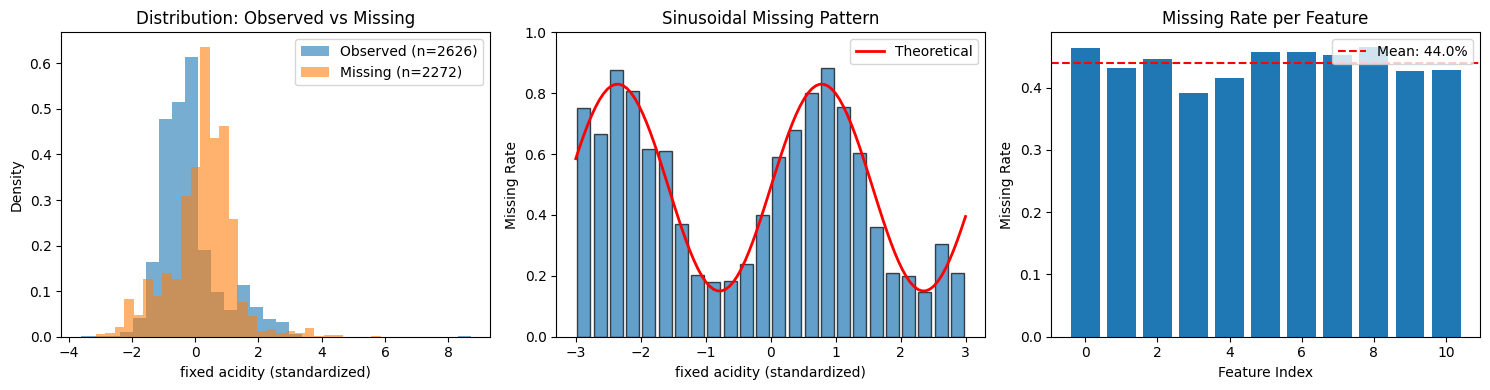


Overall missing rate: 44.0%
Sinusoidal parameters: amplitude=0.8, frequency=2.00


In [6]:
# Generate data with sinusoidal MNAR pattern
X_nan_sin, X_filled_sin, mask_sin, sin_params = introduce_sinusoidal_mnar(
    X_std, 
    amplitude=0.8,      # Strong sinusoidal effect
    frequency=2.0,      # ~3 "cycles" across standard normal range
    phase=0.0,          # No phase shift
    base_prob=0.15,     # 15% base missing rate
    seed=42
)

# Visualize the sinusoidal missing pattern for one feature
feature_idx = 0
feature_name = data.columns[feature_idx]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Histogram of observed vs missing values
ax = axes[0]
observed_vals = X_std[mask_sin[:, feature_idx] == 1, feature_idx]
missing_vals = X_std[mask_sin[:, feature_idx] == 0, feature_idx]
ax.hist(observed_vals, bins=30, alpha=0.6, label=f'Observed (n={len(observed_vals)})', density=True)
ax.hist(missing_vals, bins=30, alpha=0.6, label=f'Missing (n={len(missing_vals)})', density=True)
ax.set_xlabel(f'{feature_name} (standardized)')
ax.set_ylabel('Density')
ax.set_title('Distribution: Observed vs Missing')
ax.legend()

# Plot 2: Missing rate by value bin
ax = axes[1]
bins = np.linspace(-3, 3, 25)
bin_indices = np.digitize(X_std[:, feature_idx], bins)
missing_rates = []
bin_centers = []
for i in range(1, len(bins)):
    in_bin = bin_indices == i
    if in_bin.sum() > 0:
        rate = 1 - mask_sin[in_bin, feature_idx].mean()
        missing_rates.append(rate)
        bin_centers.append((bins[i-1] + bins[i]) / 2)

ax.bar(bin_centers, missing_rates, width=0.2, alpha=0.7, edgecolor='black')
# Overlay theoretical sinusoidal pattern
x_theory = np.linspace(-3, 3, 100)
sin_component = np.sin(sin_params['frequencies'][feature_idx] * x_theory + sin_params['phases'][feature_idx])
sin_normalized = 0.5 * (1 + sin_component)
prob_missing_theory = sin_params['base_prob'] + sin_params['amplitude'] * (1 - sin_params['base_prob']) * sin_normalized
ax.plot(x_theory, prob_missing_theory, 'r-', linewidth=2, label='Theoretical')
ax.set_xlabel(f'{feature_name} (standardized)')
ax.set_ylabel('Missing Rate')
ax.set_title('Sinusoidal Missing Pattern')
ax.legend()
ax.set_ylim(0, 1)

# Plot 3: Overall missing rates per feature
ax = axes[2]
missing_rates_per_feature = 1 - mask_sin.mean(axis=0)
ax.bar(range(D), missing_rates_per_feature)
ax.axhline(y=missing_rates_per_feature.mean(), color='r', linestyle='--', label=f'Mean: {missing_rates_per_feature.mean():.1%}')
ax.set_xlabel('Feature Index')
ax.set_ylabel('Missing Rate')
ax.set_title('Missing Rate per Feature')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nOverall missing rate: {1 - mask_sin.mean():.1%}")
print(f"Sinusoidal parameters: amplitude={sin_params['amplitude']}, frequency={sin_params['frequencies'][0]:.2f}")

In [7]:
# Create NotMIWAE model with custom SinusoidalMissingProcess
sinusoidal_missing = SinusoidalMissingProcess(
    input_dim=D,
    init_frequency=1.0,  # Will be learned
    init_amplitude=1.0,
    learn_frequency=True,
    feature_names=list(data.columns)
)

# Create the model with custom missing process
model_sin = NotMIWAE(
    input_dim = D,
    missing_process=sinusoidal_missing,  # Pass custom missing process instance
).to(device)

print("Model created with SinusoidalMissingProcess")
print(f"Learnable parameters in missing process:")
for name, param in model_sin.missing_model.named_parameters():
    print(f"  {name}: {param.shape}")

Model created with SinusoidalMissingProcess
Learnable parameters in missing process:
  amplitude: torch.Size([1, 1, 11])
  phase: torch.Size([1, 1, 11])
  bias: torch.Size([1, 1, 11])
  center: torch.Size([1, 1, 11])
  frequency: torch.Size([1, 1, 11])


In [9]:
# Train the model with sinusoidal missing data
X_train_sin = torch.tensor(X_filled_sin, dtype=torch.float32)
mask_train_sin = torch.tensor(mask_sin, dtype=torch.float32)

train_loader_sin = DataLoader(
    TensorDataset(X_train_sin, mask_train_sin, torch.tensor(X_std, dtype=torch.float32)),
    batch_size=128,
    shuffle=True
)

trainer_sin = Trainer(model_sin, device=device, lr=1e-3, original_data_available=True,  # Track imputation RMSE each epoch
    rmse_n_samples=50)

# Train for a few epochs
print("Training NotMIWAE with Sinusoidal Missing Process...")
losses_sin = trainer_sin.train(train_loader_sin)

Training NotMIWAE with Sinusoidal Missing Process...


c:\Users\adamg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\jit\_trace.py:1209: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Expected 14.369843482971191 but got 14.306390762329102.
Absolute difference: 0.06345272064208984 (up to 1e-05 allowed)
Relative difference: 0.004415686275030324 (up to 1e-05 allowed)
  _check_trace(


Model graph logged to TensorBoard: runs\NotMIWAE_20251206-153324
Epoch 10/100 - Loss: 14.4786, ELBO: -14.4786, RMSE: 1.0333
Epoch 10/100 - Loss: 14.4786, ELBO: -14.4786, RMSE: 1.0333
Epoch 20/100 - Loss: 14.2616, ELBO: -14.2616, RMSE: 0.9899
Epoch 20/100 - Loss: 14.2616, ELBO: -14.2616, RMSE: 0.9899
Epoch 30/100 - Loss: 14.0722, ELBO: -14.0722, RMSE: 0.9601
Epoch 30/100 - Loss: 14.0722, ELBO: -14.0722, RMSE: 0.9601
Epoch 40/100 - Loss: 13.9739, ELBO: -13.9739, RMSE: 0.9411
Epoch 40/100 - Loss: 13.9739, ELBO: -13.9739, RMSE: 0.9411
Epoch 50/100 - Loss: 13.8700, ELBO: -13.8700, RMSE: 0.9287
Epoch 50/100 - Loss: 13.8700, ELBO: -13.8700, RMSE: 0.9287
Epoch 60/100 - Loss: 13.8353, ELBO: -13.8353, RMSE: 0.9218
Epoch 60/100 - Loss: 13.8353, ELBO: -13.8353, RMSE: 0.9218
Epoch 70/100 - Loss: 13.7537, ELBO: -13.7537, RMSE: 0.9123
Epoch 70/100 - Loss: 13.7537, ELBO: -13.7537, RMSE: 0.9123
Epoch 80/100 - Loss: 13.7348, ELBO: -13.7348, RMSE: 0.9014
Epoch 80/100 - Loss: 13.7348, ELBO: -13.7348, RMSE

In [10]:
rmse_notmiwae, X_imputed_notmiwae = imputation_rmse(
    model=model_sin,
    x_original=torch.tensor(torch.tensor(X_std, dtype=torch.float32)),
    x_filled=torch.tensor(X_train_sin),
    mask=torch.tensor(mask_train_sin),
    n_samples=100,
    device=device,
    solver="l2"
)
print(f"\nnot-MIWAE Imputation RMSE: {rmse_notmiwae:.5f}")

C:\Users\adamg\AppData\Local\Temp\ipykernel_44540\1097353971.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_original=torch.tensor(torch.tensor(X_std, dtype=torch.float32)),
C:\Users\adamg\AppData\Local\Temp\ipykernel_44540\1097353971.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_filled=torch.tensor(X_train_sin),
C:\Users\adamg\AppData\Local\Temp\ipykernel_44540\1097353971.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask=torch.tensor(mask_train_sin),



not-MIWAE Imputation RMSE: 0.88588


In [14]:
# Mean imputation baseline
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_imputed_mean = imputer.fit_transform(X_nan_sin)

# Compute RMSE for mean imputation
missing_mask = (1 - mask_sin).astype(bool)
X_original_sin = X_std  # Original standardized data
rmse_mean = np.sqrt(np.mean((X_original_sin[missing_mask] - X_imputed_mean[missing_mask])**2))

print(f"Mean Imputation RMSE: {rmse_mean:.5f}")

Mean Imputation RMSE: 1.04839


In [15]:
# Interpret the learned sinusoidal missing process
print("Learned Sinusoidal Missing Process Parameters:")
print("=" * 60)
results = model_sin.missing_model.interpret(verbose=True)

# Compare learned vs true frequencies
print("\n\nComparison: True vs Learned")
print("-" * 40)
true_freq = sin_params['frequencies'][0]
learned_freq = results['interpretations'][0]['frequency']
print(f"Feature 0 - True frequency: {true_freq:.3f}, Learned: {learned_freq:.3f}")

Learned Sinusoidal Missing Process Parameters:
Sinusoidal Missing Process: logit(p(s=1|x)) = A*sin(f*(x-c) + φ) + b

fixed acidity:
  Amplitude: 0.445, Frequency: 0.413
  Period: 15.208, Phase: 0.373
  Values near -5.04 most likely MISSING

volatile acidity:
  Amplitude: 0.427, Frequency: 0.432
  Period: 14.533, Phase: 0.485
  Values near -5.19 most likely MISSING

citric acid:
  Amplitude: 0.554, Frequency: 0.475
  Period: 13.234, Phase: 0.382
  Values near -4.46 most likely MISSING

residual sugar:
  Amplitude: 1.024, Frequency: 1.442
  Period: 4.357, Phase: 1.440
  Values near -3.53 most likely MISSING

chlorides:
  Amplitude: 0.867, Frequency: 1.522
  Period: 4.128, Phase: 1.203
  Values near -3.06 most likely MISSING

free sulfur dioxide:
  Amplitude: 0.689, Frequency: 0.982
  Period: 6.397, Phase: 1.437
  Values near -4.47 most likely MISSING

total sulfur dioxide:
  Amplitude: 0.879, Frequency: 1.360
  Period: 4.619, Phase: 1.371
  Values near -3.54 most likely MISSING

density:

In [ ]:
# Visualize the learned missing probability curves
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(min(6, D)):
    model_sin.missing_model.plot_missing_probability(feature_idx=i, x_range=(-3, 3), ax=axes[i])
    
    # Overlay the true pattern
    x_vals = np.linspace(-3, 3, 500)
    sin_comp = np.sin(sin_params['frequencies'][i] * x_vals + sin_params['phases'][i])
    sin_norm = 0.5 * (1 + sin_comp)
    true_prob_missing = sin_params['base_prob'] + sin_params['amplitude'] * (1 - sin_params['base_prob']) * sin_norm
    axes[i].plot(x_vals, true_prob_missing, 'k:', linewidth=2, alpha=0.7, label='True P(missing)')
    axes[i].legend(fontsize=8)

plt.suptitle('Learned vs True Sinusoidal Missing Patterns', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Define directional patterns for features
# +1.0 = High values more likely missing (e.g., sensor saturation)
# -1.0 = Low values more likely missing (e.g., below detection threshold)

# For wine dataset: alternate directions across features
feature_signs = np.array([+1, +1, +1, -1, -1, -1, +1, +1, -1, -1, +1])

# Introduce directional MNAR with probabilistic mechanism
X_nan, X_filled, mask, signs_used = introduce_directional_mnar(
    X_std, 
    signs=feature_signs,
    threshold=0.0,      # Using standardized data (mean=0)
    strength=3.0,       # Controls steepness of probability curve
    base_prob=0.05      # Minimum 5% chance of missingness
)

print(f"Missing value statistics:")
print(f"Total missing rate: {(1 - mask.mean()):.2%}")
print(f"\nMissing rate per feature:")
for i, (rate, sign) in enumerate(zip(1 - mask.mean(axis=0), signs_used)):
    direction = "High→Missing" if sign > 0 else "Low→Missing"
    print(f"  Feature {i}: {rate:.2%} ({direction})")

Missing value statistics:
Total missing rate: 52.50%

Missing rate per feature:
  Feature 0: 49.67% (High→Missing)
  Feature 1: 47.57% (High→Missing)
  Feature 2: 48.29% (High→Missing)
  Feature 3: 57.35% (Low→Missing)
  Feature 4: 58.96% (Low→Missing)
  Feature 5: 54.63% (Low→Missing)
  Feature 6: 49.86% (High→Missing)
  Feature 7: 51.94% (High→Missing)
  Feature 8: 54.55% (Low→Missing)
  Feature 9: 55.74% (Low→Missing)
  Feature 10: 48.96% (High→Missing)


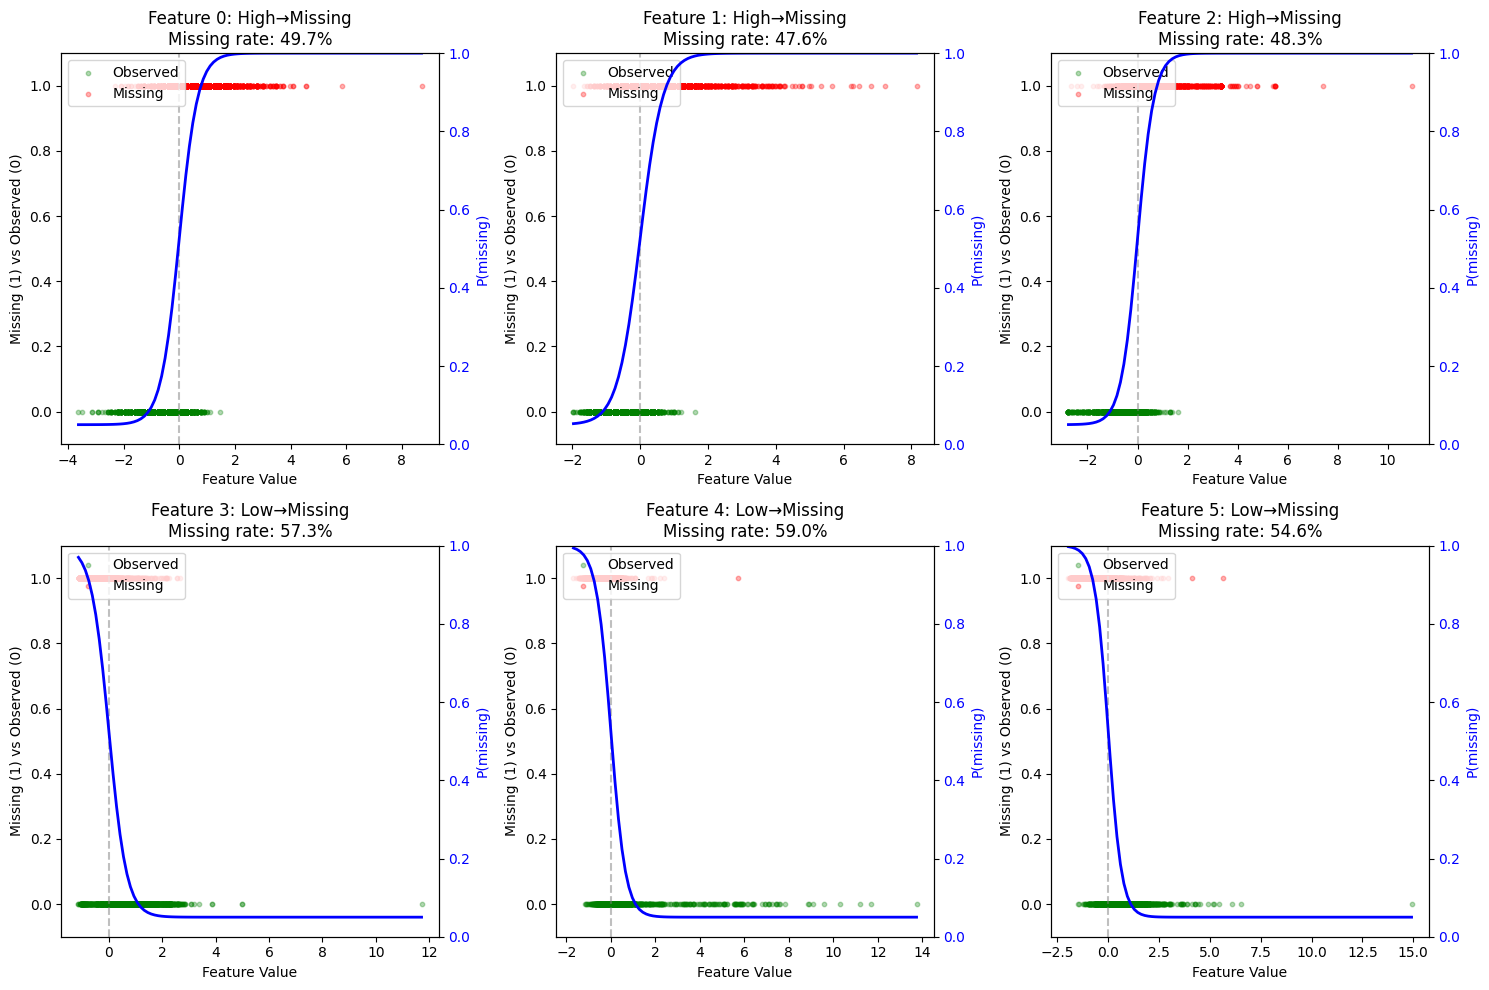

In [6]:
# Visualize the relationship between values and missingness probability
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx in range(min(6, D)):
    ax = axes[idx]
    
    # Get data for this feature
    feature_values = X_std[:, idx]
    is_missing = mask[:, idx] == 0
    sign = signs_used[idx]
    direction = "High→Missing" if sign > 0 else "Low→Missing"
    
    # Scatter plot: value vs missingness
    ax.scatter(feature_values[~is_missing], np.zeros(sum(~is_missing)), 
               alpha=0.3, s=10, label='Observed', color='green')
    ax.scatter(feature_values[is_missing], np.ones(sum(is_missing)), 
               alpha=0.3, s=10, label='Missing', color='red')
    
    # Show theoretical probability curve
    x_range = np.linspace(feature_values.min(), feature_values.max(), 100)
    signed_dist = sign * (x_range - 0.0)
    prob_curve = 0.05 + 0.95 * (1 / (1 + np.exp(-3.0 * signed_dist)))
    
    ax2 = ax.twinx()
    ax2.plot(x_range, prob_curve, 'b-', linewidth=2, label='P(missing)')
    ax2.set_ylabel('P(missing)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.set_ylim(0, 1)
    
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Missing (1) vs Observed (0)')
    ax.set_title(f'Feature {idx}: {direction}\nMissing rate: {(1-mask[:, idx].mean()):.1%}')
    ax.set_ylim(-0.1, 1.1)
    ax.legend(loc='upper left')
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='Threshold')

plt.tight_layout()
plt.show()

## 3. Create Datasets and DataLoaders

We'll split the data into training and validation sets.

In [7]:
# Create train/validation split
train_ratio = 0.8
n_train = int(N * train_ratio)

# Training data
X_train_filled = X_filled[:n_train]
mask_train = mask[:n_train]
X_train_original = X_std[:n_train]

# Validation data
X_val_filled = X_filled[n_train:]
mask_val = mask[n_train:]
X_val_original = X_std[n_train:]

print(f"Training samples: {n_train}")
print(f"Validation samples: {N - n_train}")

Training samples: 3918
Validation samples: 980


In [8]:
# Convert to PyTorch tensors
X_train_filled_t = torch.tensor(X_train_filled, dtype=torch.float32)
mask_train_t = torch.tensor(mask_train, dtype=torch.float32)
X_train_original_t = torch.tensor(X_train_original, dtype=torch.float32)

X_val_filled_t = torch.tensor(X_val_filled, dtype=torch.float32)
mask_val_t = torch.tensor(mask_val, dtype=torch.float32)
X_val_original_t = torch.tensor(X_val_original, dtype=torch.float32)

# Create TensorDatasets (x_filled, mask, x_original)
train_dataset = TensorDataset(X_train_filled_t, mask_train_t, X_train_original_t)
val_dataset = TensorDataset(X_val_filled_t, mask_val_t, X_val_original_t)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 62
Number of validation batches: 16


## 4. Create and Train the not-MIWAE Model

We'll train the not-MIWAE model with the `selfmasking_known` missing process, which assumes we know that higher values are more likely to be missing.

In [ ]:
# Model hyperparameters
latent_dim = D - 1  # Following the paper's setup
hidden_dim = 128
n_samples = 20  # Number of importance samples

# Convert signs to torch tensor for the model
signs_tensor = torch.tensor(signs_used, dtype=torch.float32)

# Create the not-MIWAE model with directional control
notmiwae = NotMIWAE(
    input_dim=D,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim,
    n_samples=n_samples,
    out_dist='gauss',
    missing_process='selfmasking_known_signs',
    # signs=signs_tensor  # Pass the directional signs
)

print(f"not-MIWAE Model:")
print(f"  Input dimension: {D}")
print(f"  Latent dimension: {latent_dim}")
print(f"  Hidden dimension: {hidden_dim}")
print(f"  Number of importance samples: {n_samples}")
print(f"  Missing process: selfmasking_known_signs with directional control")
# print(f"  Signs: {signs_used}")
print(f"\nTotal parameters: {sum(p.numel() for p in notmiwae.parameters()):,}")

not-MIWAE Model:
  Input dimension: 11
  Latent dimension: 10
  Hidden dimension: 128
  Number of importance samples: 20
  Missing process: selfmasking_known with directional control

Total parameters: 41,408


In [14]:
# Create the trainer with original_data_available=True to track RMSE during training
trainer_notmiwae = Trainer(
    model=notmiwae,
    lr=1e-3,
    device=device,
    log_dir='./runs',
    checkpoint_dir='./checkpoints',
    original_data_available=True,  # Track imputation RMSE each epoch
    rmse_n_samples=50  # Fewer samples for speed during training
)

print(f"Trainer created. Device: {trainer_notmiwae.device}")
print(f"TensorBoard logs will be saved to: {trainer_notmiwae.log_dir}")
print(f"Tracking imputation RMSE during training: {trainer_notmiwae.original_data_available}")

Trainer created. Device: cpu
TensorBoard logs will be saved to: runs\NotMIWAE_20251205-011157
Tracking imputation RMSE during training: True


In [24]:
%load_ext tensorboard
%tensorboard --logdir ./runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

In [15]:
# Train the not-MIWAE model
print("Training not-MIWAE...")
print("="*60)

history_notmiwae = trainer_notmiwae.train(
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=160,
    log_interval=20,
    save_best=True,
    early_stopping_patience=30,
    checkpoint_name='notmiwae_best.pt'
)

Training not-MIWAE...


c:\Users\adamg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\jit\_trace.py:1209: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Expected 13.035772323608398 but got 13.059471130371094.
Absolute difference: 0.023698806762695312 (up to 1e-05 allowed)
Relative difference: 0.001817982561706425 (up to 1e-05 allowed)
  _check_trace(


Model graph logged to TensorBoard: runs\NotMIWAE_20251205-011157
Epoch 20/160 - Loss: 12.4983, ELBO: -12.4983, RMSE: 1.5328 | Val Loss: 12.4955, Val RMSE: 1.5190
Epoch 20/160 - Loss: 12.4983, ELBO: -12.4983, RMSE: 1.5328 | Val Loss: 12.4955, Val RMSE: 1.5190


KeyboardInterrupt: 

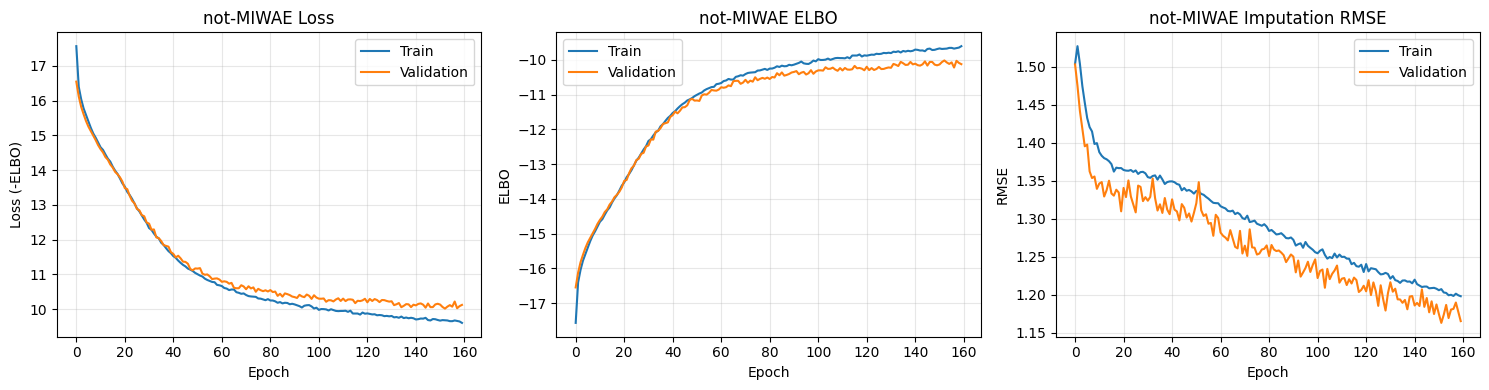


Final Validation RMSE: 1.16504


In [12]:
# Plot training history including RMSE
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
axes[0].plot(history_notmiwae['train_loss'], label='Train')
if history_notmiwae.get('val_loss'):
    axes[0].plot(history_notmiwae['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (-ELBO)')
axes[0].set_title('not-MIWAE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ELBO curves
axes[1].plot(history_notmiwae['train_elbo'], label='Train')
if history_notmiwae.get('val_elbo'):
    axes[1].plot(history_notmiwae['val_elbo'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('ELBO')
axes[1].set_title('not-MIWAE ELBO')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# RMSE curves
if history_notmiwae.get('train_rmse'):
    axes[2].plot(history_notmiwae['train_rmse'], label='Train')
    if history_notmiwae.get('val_rmse'):
        axes[2].plot(history_notmiwae['val_rmse'], label='Validation')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('RMSE')
    axes[2].set_title('not-MIWAE Imputation RMSE')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('notmiwae_training.png', dpi=150)
plt.show()

# Print final RMSE
if history_notmiwae.get('val_rmse'):
    print(f"\nFinal Validation RMSE: {history_notmiwae['val_rmse'][-1]:.5f}")

## 5. Train the Standard MIWAE for Comparison

For comparison, we'll also train the standard MIWAE which doesn't model the missing process.

In [13]:
# Create the MIWAE model (without missing process modeling)
miwae = MIWAE(
    input_dim=D,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim,
    n_samples=n_samples,
    out_dist='gauss'
)

print(f"MIWAE Model (no missing process):")
print(f"  Total parameters: {sum(p.numel() for p in miwae.parameters()):,}")

MIWAE Model (no missing process):
  Total parameters: 41,386


In [ ]:
# Create trainer for MIWAE with RMSE tracking
trainer_miwae = Trainer(
    model=miwae,
    lr=1e-3,
    device=device,
    log_dir='./runs',
    checkpoint_dir='./checkpoints',
    original_data_available=True,
    rmse_n_samples=50
)


# Train MIWAE
print("\nTraining MIWAE...")
print("="*60)

history_miwae = trainer_miwae.train(
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=150,
    log_interval=20,
    save_best=True,
    early_stopping_patience=30,
    checkpoint_name='miwae_best.pt'
)


Training MIWAE...
Model graph logged to TensorBoard: runs\MIWAE_20251205-003751


c:\Users\adamg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\jit\_trace.py:1209: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Expected 11.300376892089844 but got 11.741588592529297.
Absolute difference: 0.4412117004394531 (up to 1e-05 allowed)
Relative difference: 0.039043980979811134 (up to 1e-05 allowed)
  _check_trace(


Epoch 20/150 - Loss: 7.9420, ELBO: -7.9420, RMSE: 1.5745 | Val Loss: 7.9270, Val RMSE: 1.5448
Epoch 40/150 - Loss: 7.7401, ELBO: -7.7401, RMSE: 1.5663 | Val Loss: 7.8360, Val RMSE: 1.5336
Epoch 60/150 - Loss: 7.5682, ELBO: -7.5682, RMSE: 1.5659 | Val Loss: 7.6651, Val RMSE: 1.5237
Epoch 80/150 - Loss: 7.5130, ELBO: -7.5130, RMSE: 1.5621 | Val Loss: 7.6027, Val RMSE: 1.5293
Epoch 100/150 - Loss: 7.4642, ELBO: -7.4642, RMSE: 1.5625 | Val Loss: 7.5731, Val RMSE: 1.5346
Epoch 120/150 - Loss: 7.4012, ELBO: -7.4012, RMSE: 1.5629 | Val Loss: 7.5814, Val RMSE: 1.5009
Epoch 140/150 - Loss: 7.2940, ELBO: -7.2940, RMSE: 1.5528 | Val Loss: 7.4969, Val RMSE: 1.5048

Training completed in 189.55s


## 6. Evaluate Imputation Performance

Now let's compare the imputation performance of both models.

In [16]:
# Load best models
trainer_notmiwae.load_checkpoint('notmiwae_best.pt')
trainer_miwae.load_checkpoint('miwae_best.pt')

# Compute imputation RMSE
n_imp_samples = 1000  # More samples for better imputation

print("Computing imputation RMSE...")
print("="*60)

Computing imputation RMSE...


In [19]:
# not-MIWAE imputation
rmse_notmiwae, X_imputed_notmiwae = imputation_rmse(
    model=notmiwae,
    x_original=torch.tensor(X_train_original),
    x_filled=torch.tensor(X_train_filled),
    mask=torch.tensor(mask_train),
    n_samples=n_imp_samples,
    device=device,
    solver="l2"
)

print(f"\nnot-MIWAE Imputation RMSE: {rmse_notmiwae:.5f}")


not-MIWAE Imputation RMSE: 1.19744


In [20]:
# MIWAE imputation
rmse_miwae, X_imputed_miwae = imputation_rmse(
    model=miwae,
    x_original=torch.tensor(X_train_original),
    x_filled=torch.tensor(X_train_filled),
    mask=torch.tensor(mask_train),
    n_samples=n_imp_samples,
    device=device
)

print(f"\nMIWAE Imputation RMSE: {rmse_miwae:.5f}")


MIWAE Imputation RMSE: 1.56621


In [16]:
# Mean imputation baseline
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_imputed_mean = imputer.fit_transform(X_nan[:n_train])

# Compute RMSE for mean imputation
missing_mask = (1 - mask_train).astype(bool)
rmse_mean = np.sqrt(np.mean((X_train_original[missing_mask] - X_imputed_mean[missing_mask])**2))

print(f"Mean Imputation RMSE: {rmse_mean:.5f}")

Mean Imputation RMSE: 1.48134


In [ ]:
# Summary of results
print("\n" + "="*60)
print("IMPUTATION RESULTS SUMMARY")
print("="*60)
print(f"Method               | RMSE")
print("-"*40)
print(f"Mean Imputation      | {rmse_mean:.5f}")
print(f"MIWAE                | {rmse_miwae:.5f}")
print(f"not-MIWAE            | {rmse_notmiwae:.5f}")
print("-"*40)

improvement = (rmse_miwae - rmse_notmiwae) / rmse_miwae * 100
print(f"\nnot-MIWAE improvement over MIWAE: {improvement:.2f}%")

## 7. Interpret the Missing Process

One unique feature of not-MIWAE is the ability to interpret the learned missing process. We can analyze which features influence the probability of missingness.

In [ ]:
# Get feature names from the dataset
feature_names = list(data.drop('quality', axis=1).columns)

# Create a new model with feature names for interpretation
notmiwae_interp = NotMIWAE(
    input_dim=D,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim,
    n_samples=n_samples,
    out_dist='gauss',
    missing_process='selfmasking_known_signs',
    feature_names=feature_names
)

# Load the trained weights
notmiwae_interp.load_state_dict(notmiwae.state_dict())
notmiwae_interp.eval()

# Interpret the missing process
interpretation = notmiwae_interp.interpret_missing_process()
print(interpretation)

In [ ]:
# Visualize missing process coefficients
import torch.nn.functional as F

fig, ax = plt.subplots(figsize=(12, 5))

# For selfmasking_known_signs, we have per-feature coefficients
# The missing process uses logit(p(s=1|x)) = -W * (x - b)
# Access through missing_model (not missing_process)
W = F.softplus(notmiwae_interp.missing_model.W).detach().squeeze().cpu().numpy()
b = notmiwae_interp.missing_model.b.detach().squeeze().cpu().numpy()

# Plot W coefficients for each feature
x_pos = np.arange(D)
colors = ['red' if w > 0.5 else 'blue' for w in W]

bars = ax.bar(x_pos, W, color=colors, alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_xlabel('Feature')
ax.set_ylabel('Missing Process Weight (W)')
ax.set_title('Missing Process Coefficients\n(Higher W = stronger self-masking effect)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('missing_process_interpretation.png', dpi=150)
plt.show()

print("\nNote: In self-masking MNAR, the model learns: logit(p(s=1|x)) = -W*(x-b)")
print("Larger W means higher values are more likely to be missing.")
print(f"The first {D//2} features were made MNAR in our simulation.")

## 8. Visualize Imputation Results

In [ ]:
# Visualize imputation for a specific feature
feature_idx = 0  # First feature (has MNAR missing values)
missing_idx = mask_train[:, feature_idx] == 0

fig, ax = plt.subplots(figsize=(12, 6))

# Sample indices for visualization
n_show = min(50, missing_idx.sum())
sample_indices = np.where(missing_idx)[0][:n_show]

# Plot original values, filled values, and imputed values
x_pos = np.arange(n_show)
width = 0.2  # Narrower bars to fit 4 groups

ax.bar(x_pos - 1.5*width, X_train_original[sample_indices, feature_idx], width, label='Original (true)', alpha=0.8, color='C0')
ax.bar(x_pos - 0.5*width, X_train_filled[sample_indices, feature_idx], width, label='Filled (mean)', alpha=0.8, color='C1')
ax.bar(x_pos + 0.5*width, X_imputed_miwae[sample_indices, feature_idx], width, label='MIWAE imputed', alpha=0.8, color='C2')
ax.bar(x_pos + 1.5*width, X_imputed_notmiwae[sample_indices, feature_idx], width, label='not-MIWAE imputed', alpha=0.8, color='C3')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Value')
ax.set_title(f'Imputation Comparison for Feature {feature_idx}\n(showing {n_show} missing values)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('imputation_comparison.png', dpi=150)
plt.show()

In [ ]:
# Compare imputation methods for a specific feature
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

feature_idx = 0  # Feature with MNAR missing values
missing_idx = mask_train[:, feature_idx] == 0

# Scatter plot: Original vs Imputed
axes[0].scatter(X_train_original[missing_idx, feature_idx], 
                X_imputed_mean[missing_idx, feature_idx], 
                alpha=0.5, label='Mean')
axes[0].scatter(X_train_original[missing_idx, feature_idx], 
                X_imputed_miwae[missing_idx, feature_idx], 
                alpha=0.5, label='MIWAE')
axes[0].scatter(X_train_original[missing_idx, feature_idx], 
                X_imputed_notmiwae[missing_idx, feature_idx], 
                alpha=0.5, label='not-MIWAE')

# Perfect imputation line
lim = [X_train_original[missing_idx, feature_idx].min(), 
       X_train_original[missing_idx, feature_idx].max()]
axes[0].plot(lim, lim, 'k--', label='Perfect')

axes[0].set_xlabel('Original Value')
axes[0].set_ylabel('Imputed Value')
axes[0].set_title(f'Imputation Quality (Feature {feature_idx})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error distribution
errors_mean = X_imputed_mean[missing_idx, feature_idx] - X_train_original[missing_idx, feature_idx]
errors_miwae = X_imputed_miwae[missing_idx, feature_idx] - X_train_original[missing_idx, feature_idx]
errors_notmiwae = X_imputed_notmiwae[missing_idx, feature_idx] - X_train_original[missing_idx, feature_idx]

axes[1].hist(errors_mean, bins=30, alpha=0.5, label=f'Mean (bias={errors_mean.mean():.3f})')
axes[1].hist(errors_miwae, bins=30, alpha=0.5, label=f'MIWAE (bias={errors_miwae.mean():.3f})')
axes[1].hist(errors_notmiwae, bins=30, alpha=0.5, label=f'not-MIWAE (bias={errors_notmiwae.mean():.3f})')
axes[1].axvline(x=0, color='k', linestyle='--')
axes[1].set_xlabel('Imputation Error')
axes[1].set_ylabel('Count')
axes[1].set_title('Error Distribution')
axes[1].legend()

# Box plot of absolute errors
abs_errors = [np.abs(errors_mean), np.abs(errors_miwae), np.abs(errors_notmiwae)]
bp = axes[2].boxplot(abs_errors, labels=['Mean', 'MIWAE', 'not-MIWAE'])
axes[2].set_ylabel('Absolute Error')
axes[2].set_title('Absolute Error Distribution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('imputation_analysis.png', dpi=150)
plt.show()

## 9. TensorBoard Visualization

To view the training logs in TensorBoard, run the following command in your terminal:

```bash
tensorboard --logdir=./runs
```

Then open your browser to http://localhost:6006

## 10. Conclusion

In this notebook, we demonstrated:

1. **Data Preparation**: Loading the UCI Wine Quality dataset and introducing MNAR missing values
2. **Model Training**: Training both not-MIWAE (with missing process modeling) and standard MIWAE
3. **Imputation Evaluation**: Comparing imputation performance using RMSE
4. **Missing Process Interpretation**: Analyzing the learned missing mechanism
5. **Visualization**: Analyzing imputation quality and error distributions

### Key Findings:
- The not-MIWAE model, which explicitly models the self-masking missing mechanism, achieves better imputation performance on MNAR data
- Standard MIWAE (which assumes MCAR) produces biased imputations for MNAR data
- Mean imputation is the worst baseline, as it ignores the relationship between features
- The `interpret_missing_process()` method reveals which features have learned positive/negative associations with missingness

### When to Use not-MIWAE:
- When you suspect the missing data mechanism is MNAR
- When you have prior knowledge about the missing mechanism (e.g., self-censoring, detection limits)
- When standard imputation methods produce biased results
- When you need to interpret *why* data is missing